In [1]:
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from today
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
precip_df = pd.DataFrame(precip)
precip_df.head(10)

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45
7,2016-08-25,0.08
8,2016-08-25,0.08
9,2016-08-25,0.00


In [15]:
# Sort the dataframe by date
precip_df.set_index('date').head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


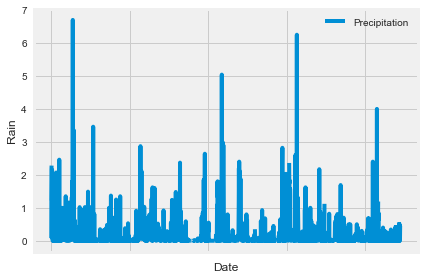

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates#plot the dataframe
precip_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
Active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

Most_Active = Active_station[0][0]    
print("The most active station is",Most_Active,"with",Active_station[0][1],"observation counts.")
print()
print("Below are all of the stations with their observation counts:")
for station, count in Active_station:
    print("Station",station,"had",count, "observation counts.")

The most active station is USC00519281 with 2772 observation counts.

Below are all of the stations with their observation counts:
Station USC00519281 had 2772 observation counts.
Station USC00519397 had 2724 observation counts.
Station USC00513117 had 2709 observation counts.
Station USC00519523 had 2669 observation counts.
Station USC00516128 had 2612 observation counts.
Station USC00514830 had 2202 observation counts.
Station USC00511918 had 1979 observation counts.
Station USC00517948 had 1372 observation counts.
Station USC00518838 had 511 observation counts.


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == Most_Active).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

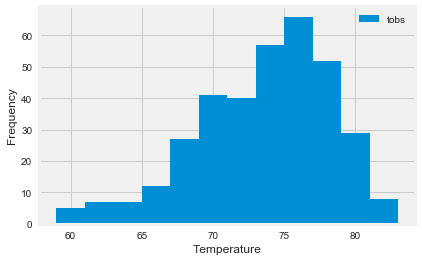

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_df=pd.DataFrame(Temp)
plt.hist(Temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018,1,1)
trip_leave = dt.date(2018,1,7)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(62.0, 68.36585365853658, 74.0)]


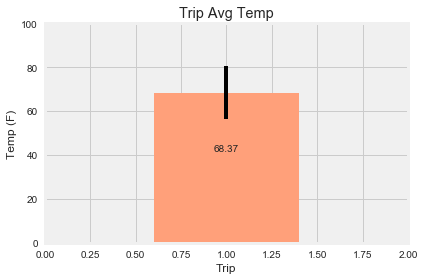

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
prep = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'lightsalmon', yerr=prep)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()


In [25]:
stations = Base.classes.station

list(stations.__table__.columns)

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [26]:
measurements = Base.classes.measurement

list(measurements.__table__.columns)

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

2017-01-01
2017-01-07


In [28]:
rainfall_by_station_lastyear = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_by_station_lastyear

[('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.4899999999999975),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.3999999999999995),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.399999999999996),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.1500000000000004),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.8000000000000012),
 ('USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0)]